In [4]:
import numpy as np 
from numpy import random as npr
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
def sigmoid(z):
    return((1 + np.exp(-z))**(-1))

def ReLU(Z):
    return np.maximum(Z, 0)

def regularize(m):
    return(m/np.sum(m))

def weighted_cross_entropy(y, p, m):
    return -sum(m*(y*np.log(p) + (1-y)*np.log(1-p)))

def pFromX(X, seed = 123):
    npr.seed(seed)
    T = X @ npr.randn(D, 7)/1.5
    T += sigmoid(T)
    T -= np.exp(T/5)
    T = T @ npr.randn(T.shape[1], 4)/1.5
    T -= np.tile(T.mean(0), T.shape[0]).reshape(T.shape)
    T /= np.tile(T.std(0), T.shape[0]).reshape(T.shape)/(10)
    p = sigmoid(T.mean(1) - T.mean())
    return p



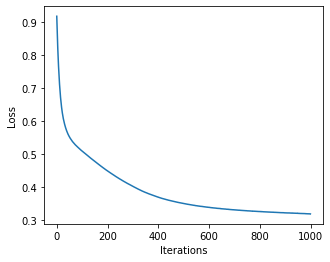

In [6]:
class NN():
    
    def __init__(self, name = None):
        self.name = name
        
    def generate_data(self, N, D, pFromX, seed = 123):
        npr.seed(seed)
        self.N, self.D = N, D
        self.m = np.repeat(1/N, N).reshape(N, 1)
        mu = npr.randn(D) # means
        Sigma = np.eye(D) # covariance
        self.X = npr.multivariate_normal(mu, Sigma, size = N) # get data (X)
        self.latent_p = pFromX(self.X) # get latent P
        self.y = npr.binomial(1, self.latent_p, N).reshape(N, 1) # true outcome values
      
    def add_data(self, X, pFromX, seed = 123):
        npr.seed(seed)
        self.N, self.D = X.shape
        self.m = np.repeat(1/self.N, self.N).reshape(N, 1)
        self.X = X
        self.latent_p = pFromX(X)
        self.y = npr.binomial(1, self.latent_p, N).reshape(N, 1)
        
    def get_output(self):        
        self.Z1 = (self.X @ self.W1) + self.B1
        self.A1 = ReLU(self.Z1)
        self.Z2 = (self.A1 @ self.W2) + self.B2
        self.A2 = sigmoid(self.Z2)
        self.L = weighted_cross_entropy(self.y, self.A2, self.m)
        
    def get_batch(self, batch):
        # data
        self.Xb = self.X[batch]
        self.yb = self.y[batch]
        self.mb = self.m[batch]
        # intermediate stuff
        self.Z1b = (self.Xb @ self.W1) + self.B1
        self.A1b = ReLU(self.Z1b)
        self.Z2b = (self.A1b @ self.W2) + self.B2
        self.A2b = sigmoid(self.Z2b)
        # update probs in original 
        self.A2[batch] = self.A2b
    
    def get_loss(self):
        self.L = weighted_cross_entropy(self.y, self.A2, self.m)[0]
        
    def get_derivatives(self, batch):
        # update batch
        self.get_batch(batch)
        
        # change old derivatives to momentum terms 
        self.W1mom = self.dLdW1
        self.B1mom = self.dLdB1
        self.W2mom = self.dLdW2
        self.B2mom = self.dLdB2

        # get derivatives of loss function
        self.dLdA2 = (self.mb*(-self.yb/self.A2b + (1-self.yb)/(1-self.A2b))) # (B, 1)
        self.dLdZ2 = self.dLdA2 * sigmoid(self.Z2b)*(1-sigmoid(self.Z2b)) # (B, 1)
        self.dLdB2 = self.dLdZ2.sum(0) # 1
        self.dLdW2 = (self.dLdZ2.T @ self.A1b).T # (h, 1)
        self.dLdA1 = self.dLdZ2 @ self.W2.T  # (B, h)
        self.dLdZ1 = self.dLdA1 * (self.Z1b > 0) # (B, h)
        self.dLdB1 = self.dLdZ1.sum(0) # h
        self.dLdW1 = (self.dLdZ1.T @ self.Xb).T # (D, h)
        
    def update_parameters(self):
        self.W1 -= self.lr*self.dLdW1 + self.momentum*self.W1mom
        self.B1 -= self.lr*self.dLdB1 + self.momentum*self.B1mom
        self.W2 -= self.lr*self.dLdW2 + self.momentum*self.W2mom
        self.B2 -= self.lr*self.dLdB2 + self.momentum*self.B2mom
        
    def train(self, layers, h, lr, epochs, batch_size, momentum):
        # add parameters
        self.layers = layers
        self.h = h 
        self.lr = lr
        self.epochs = epochs 
        self.batch_size = batch_size
        self.momentum = momentum
        
        # instantiate parameters randomly and get outputs
        self.W1 = npr.randn(self.D*self.h).reshape((self.D, self.h))
        self.B1 = npr.randn(self.h)
        self.W2 = npr.randn(self.h).reshape((self.h, 1))
        self.B2 = npr.randn(1)
        self.get_output()
        
        # instantiate derivatives (to be used as initial momentum terms)
        self.dLdW1 = 0
        self.dLdB1 = 0
        self.dLdW2 = 0
        self.dLdB2 = 0
        
        # loop
        self.losses = []
        n_batches = self.N // self.batch_size
        for epoch in range(epochs):
            batch_indices = np.split(npr.permutation(np.arange(self.N)), n_batches)
            for i, batch in enumerate(batch_indices):
                self.get_derivatives(batch)
                self.update_parameters()
            self.get_loss()
            self.losses.append(self.L)
        self.get_output() # get output for all observations
        
    def plot_losses(self):
        fig, ax = plt.subplots(figsize = (5, 4))
        sns.lineplot(np.arange(self.epochs), self.losses)
        ax.set(xlabel = 'Iterations', ylabel = 'Loss');
        
    def plot_ps(self):
        fig, ax = plt.subplots(figsize = (5, 4))
        sns.scatterplot(self.latent_p, self.A2)
        sns.lineplot(np.arange(2), np.arange(2))
        ax.set(xlabel = 'latent p', ylabel = 'p');        

N, D = 100, 4
layers, h, lr, epochs, batch_size, momentum = 2, 3, 0.01, 1000, 10, 0.01
nn = NN()
nn.generate_data(N, D, pFromX)
nn.train(layers, h, lr, epochs, batch_size, momentum)
nn.plot_losses()
